<a href="https://colab.research.google.com/github/henrykohl/Machine-Learning-demo-repo/blob/master/OnlineLectures/StatQuest/word-embedding-with-pytorch-lightning/statquest_word_embedding_with_pytorch_lightning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# StatQuest: Word Embedding in PyTorch + Lightning!!!
<!-- ## Brought to you by...
[<img src="./images/Brandmark_FullColor_Black.png" alt="Lightning" style="width: 400px;">](https://www.pytorchlightning.ai/)
 -->
Copyright 2023, Joshua Starmer

----
**NOTE:** This tutorial is from the StatQuest **[Word Embedding in PyTorch + Lightning](https://youtu.be/Qf06XDYXCXI)**.

In this tutorial, we will use **[PyTorch](https://pytorch.org/) **+** [Lightning](https://www.lightning.ai/)** to create and optimize word embeddings using the incredibly simple network seen below and featured in the **StatQuest** **[Word Embedding and Word2Vec, Clearly Explained!!](https://youtu.be/viZrOnJclY0)**

<img src="https://github.com/henrykohl/Machine-Learning-demo-repo/blob/master/OnlineLectures/StatQuest/word-embedding-with-pytorch-lightning/images/word_embedding_network.png?raw=1" alt="A simple word embedding network" style="width: 600px;">

In that **StatQuest**, this simple network created word embeddings that made two movie titles, **Troll 2** and **Gymkata**, cluster together because they were used in similar contexts.

<img src="https://github.com/henrykohl/Machine-Learning-demo-repo/blob/master/OnlineLectures/StatQuest/word-embedding-with-pytorch-lightning/images/trained_embedding_graph.png?raw=1" alt="A graph of the trained word embeddings" style="width: 300px;">

<!-- The training data consists of two phrases, **Troll 2 is great!** and **Gymkata is great!**, where, for the sake of this demonstration, **Troll 2** is considered a single word. -->

In this tutorial, you will...

- **[Build and train a Word Embedding Unit from scratch](#build_entirely_by_hand)**

- **[Build and train a Word Embedding Unit using `nn.Linear()`](#build_entirely_with_linear)**

- **[Use `nn.Embedding()` to load and use pre-trained Word Embeddings](#embedding_lookup)**

- **BONUS BAM: [Build and train a word Word Embedding Unit using `nn.Embedding()` and `nn.Linear()`](#build_with_embedding)**


#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the theory behind **[Neural Networks](https://youtu.be/CqOfi41LfDw)**, **[Backpropagation](https://youtu.be/IN2XmBhILt4)**, and **[Word Embedding](https://youtu.be/viZrOnJclY0)**. If not, check out the **'Quests** by clicking on the links for each topic.

#### ALSO NOTE:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

-----

# Import the modules that will do all the work

The very first thing we need to do is load a bunch of Python modules. Python itself is just a basic programming language. These modules give us extra functionality to create a neural network, use and graph the output for various input values, and optimize the neural network's parameters.

<!-- You will need **Python 3.8** and have at least these versions for each of the following modules:
- pytorch >= 1.10.1
- lightning >= 1.8.0

**If you installed **Python** with [Anaconda](https://www.anaconda.com/)...**

...then you can check which versions of each package you have with the command: `conda list`. If, for example, your version of `matplotlib` is older than **3.3.4**, then the easiest thing to do is just update all of your Anaconda packages with the following command: `conda update --all`. However, if you only want to update `matplotlib`, then you can run this command: `conda install matplotlib=3.3.4`.

**If you need to install **PyTorch**...**

...then the easiest thing to do is follow the instructions on the [PyTorch website](https://pytorch.org/get-started/locally/).

**If you need to install **Lightning**...**

...then the easiest thing to do is follow the instructions on the [Lightning AI website](https://lightning.ai/lightning-docs/). -->

In [ ]:
import torch # torch will allow us to create tensors.
import torch.nn as nn # torch.nn allows us to create a neural network and allows
                      # us to access a lot of useful functions like:
                      # nn.Linear, nn.Embedding, nn.CrossEntropyLoss() etc.

from torch.optim import Adam # optim contains many optimizers. This time we're using Adam
from torch.distributions.uniform import Uniform # So we can initialize our tensors with a uniform distribution
from torch.utils.data import TensorDataset, DataLoader # these are needed for the training data

import lightning as L # lightning has tons of cool tools that make neural networks easier

import pandas as pd ## to create dataframes from graph input
import matplotlib.pyplot as plt ## matplotlib allows us to draw graphs.
import seaborn as sns ## seaborn makes it easier to draw nice-looking graphs.

----

# Create the datasets that we will use for training the word embeddings

Now let's create our training data from two phrases, **Troll 2 is great** and **Gymkata is great**, which gives us a simple 4 word, or token, vocabulary: **Troll 2**, **is**, **great**, **Gymkata**. Our training data consists of two parts: `inputs`, the inputs to the neural network, and `labels`, the expected outputs from the neural networks.

The idea is to have each token in a phrase predict the token that follows. For example, using **one-hot-encoding** to represent each token, since **Troll 2** is the first token in our vocalbuary, we will encode the `input` for **Troll 2** with `[1., 0., 0., 0.]`. And since **Troll 2** predicts the second token, **is**, which is the second token in our vocabulary, we will encode the `label` for **Troll 2** with `[0., 1., 0., 0.]`. Likewise, we can encode the `inputs` and `labels` for **is**, **great** and **Gymkata**. **NOTE: Gymkata** predicts the second token, **is**, so it's label is `[0., 1., 0., 0.]`.

In [ ]:
## create the training data for the neural network.
inputs = torch.tensor([[1., 0., 0., 0.], # one-hot-encoding for Troll 2...
                       [0., 1., 0., 0.], # ...is
                       [0., 0., 1., 0.], # ...great
                       [0., 0., 0., 1.]]) # ...Gymkata

labels = torch.tensor([[0., 1., 0., 0.], # "Troll 2" is followed by "is"
                       [0., 0., 1., 0.], # "is" is followed by "great"
                       [0., 0., 0., 1.], # "great" isn't followed by anything, but we'll pretend it was followed by "Gymkata"
                       [0., 1., 0., 0.]]) # "Gymkata", just like "Troll 2", is followed by "is".

Now that we have created the data that we want to train the embeddings with, we'll store it in a `DataLoader`. Since our dataset is so small, using a `DataLoader` is a little bit of an overkill, but it it's easy to do, and it will allow us to easily scale up to a much larger vocabulary when the time comes.

In [ ]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

----
<a id="build_entirely_by_hand"></a>
# Build and train a Word Embedding Unit from scratch

Now that we have the data and `DataLoader` all worked out, let's create the `class` that will create the word embeddings for each token in the vacublary.

In [30]:
class WordEmbeddingFromScratch(L.LightningModule):

    def __init__(self):
        ## __init__() initializes the weights and sets everything up for training

        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        L.seed_everything(seed=42)

        ###################
        ##
        ## Initialize the weights.
        ##
        ## NOTE: We're initializing the weights using values from a uniform distribtion
        ##       that goes from -0.5 to 0.5 (this is notated as U(-0.5, 0.5).
        ##       This is because of how nn.Linear() initializes weights -
        ##       nn.Linear() uses U(-sqrt(k), sqrt(k)), where k=1/in_features.
        ##       In our case, we have 4 inputs, so k=1/4 = 0.25. And the sqrt(0.25) = 0.5.
        ##       Thus, nn.Linear() would use U(-0.5, 0.5) to initialize the weights, so
        ##       that's what we'll do here as well.
        ##
        ###################
        min_value = -0.5
        max_value = 0.5

        ## Now we initialize the weights that feed 4 inputs (one for each unique word)
        ##       into the 2 nodes in the hidden layer (top and bottom nodes)
        ##
        ## NOTE: Because we want words (or tokens) that are used in the same context to have similar
        ##       weights, we are excluding bias terms from the connections from the inputs to the
        ##       nodes in the hidden layer (alternatively, you could think that
        ##       we set the bias terms to 0 and are not going to optimize them).
        ##
        ## ALSO NOTE: We're using nn.Parameter() here instead of torch.tensor() because we want
        ##       to easily print out the parameters before and after training. Parameters are just
        ##       tensors that are added to model's parameter list.
        self.input1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.input4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.input4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        ## Now we initialize the weights that come out of the hidden layer to the "output"
        ## NOTE: Again, we are excluding bias terms. This time, we exclude them simply because
        ##       we do not need them.
        self.output1_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output1_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output2_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output2_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output3_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output3_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        self.output4_w1 = nn.Parameter(Uniform(min_value, max_value).sample())
        self.output4_w2 = nn.Parameter(Uniform(min_value, max_value).sample())

        ## For the loss function, we'll use CrossEntropyLoss, which we'll use in training_step()
        ## NOTE: The nn.CrossEntropyLoss automatically applies softmax for us, so we don't need to import it.
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):
        ## forward() is where we do the math associated with running the inputs through the
        ## network

        ## The input is delivered inside of a list, like this...
        ##   [[1., 0., 0., 0.]]
        ## ...and it's just easier if we remove the extra pair of brackets so we only have...
        ##   [1., 0., 0., 0.]
        ## ...so let's do it.
        input = input[0]

        ## First, for the top node in the hidden layer,
        ## we multiply each input by its weight,
        ## and then calculate the sum of those products...
        inputs_to_top_hidden = ((input[0] * self.input1_w1) +
                                (input[1] * self.input2_w1) +
                                (input[2] * self.input3_w1) +
                                (input[3] * self.input4_w1))

        ## ...then, for the bottom node in the hidden layer,
        ## we multiply each input by its weight,
        ## and then calculate the sum of those products.
        inputs_to_bottom_hidden = ((input[0] * self.input1_w2) +
                                   (input[1] * self.input2_w2) +
                                   (input[2] * self.input3_w2) +
                                   (input[3] * self.input4_w2))

        ## Now, in theory, we could run inputs_to_top_hidden and inputs_to_bottom_hidden through
        ## linear activation functions, but the outputs would be the exact same as in the inputs,
        ## so we can just skip that step and instead compute the 4 output values from the 2 nodes in hidden layer
        ## by summing the products of the hidden layer values and a pair of weights for each output.
        output1 = ((inputs_to_top_hidden * self.output1_w1) +
                   (inputs_to_bottom_hidden * self.output1_w2))
        output2 = ((inputs_to_top_hidden * self.output2_w1) +
                   (inputs_to_bottom_hidden * self.output2_w2))
        output3 = ((inputs_to_top_hidden * self.output3_w1) +
                   (inputs_to_bottom_hidden * self.output3_w2))
        output4 = ((inputs_to_top_hidden * self.output4_w1) +
                   (inputs_to_bottom_hidden * self.output4_w2))

        ## Now we need to concatenate the 4 output tensors so that we can run them through
        ## the SoftMax function. However, because they are tensors (and have gradients attached to them),
        ## we can't just combine them in a simple list like this...
        # output_values = [output1, output2, output3, output4] ## THIS WILL NOT WORK
        ## ...because that would strip off the gradients.
        ## Instead, we use torch.stack(), which retains the gradients.
        output_presoftmax = torch.stack([output1, output2, output3, output4])
        ## NOTE: The the loss function we are using, nn.CrossEntropyLoss, automatically applies softmax for us, so we
        ##       need to do that ourselves. If we want to actually use this network to predict the next word
        ##       (instead of just using it for the Word Embedding values), then we'll need to apply the softmax() function
        ##       ourselves (or just look to see what output value is largest).

        return(output_presoftmax)


    def configure_optimizers(self):
        # configure_optimizers() configures the optimizer we want to use for backpropagation.

        return Adam(self.parameters(), lr=0.1) # lr=0.1 sets the learning rate to 0.1


    def training_step(self, batch, batch_idx):
        # training_step() takes a step of gradient descent.

        input_i, label_i = batch # collect input
        output_i = self.forward(input_i) # run input through the neural network
        loss = self.loss(output_i, label_i[0]) ## loss = cross entropy
        print(">>",output_i,label_i[0],loss)

        return loss

Now that we have created our new `class`, `WordEmbeddingFromScratch`, let's create a model and print out the initial parameters.

In [38]:
modelFromScratch = WordEmbeddingFromScratch() # create the model...

print("Before optimization, the parameters are...")
for name, param in modelFromScratch.named_parameters():
    print(name, torch.round(param.data, decimals=2))

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Before optimization, the parameters are...
input1_w1 tensor(0.3800)
input1_w2 tensor(0.4200)
input2_w1 tensor(-0.1200)
input2_w2 tensor(0.4600)
input3_w1 tensor(-0.1100)
input3_w2 tensor(0.1000)
input4_w1 tensor(-0.2400)
input4_w2 tensor(0.2900)
output1_w1 tensor(0.4400)
output1_w2 tensor(-0.3700)
output2_w1 tensor(0.4300)
output2_w2 tensor(0.0900)
output3_w1 tensor(0.3700)
output3_w2 tensor(0.0700)
output4_w1 tensor(0.2400)
output4_w2 tensor(-0.0700)


Notice how the weights for **input1** (`w1 = 0.3832` and `w2 = 0.4150`) and **input4** (`w1 = -0.2434` and `w2 = 0.2936`) are very different, even though they both represent movie titles (**Troll2** and **Gymkata**) that are used in the same context. We can visualize how similar, and different, the embeddings are for all four tokens by plotting them on a graph that has the **w1** values, the embedding values that go to the top node in the hidden layer, on the x-axis and the **w2** values, the embedding values that go to the bottom node in the hidden layer, on the y-axis. First, let's organize the data into a Pandas `DataFrame()`.

In [28]:
data = {
    "w1": [modelFromScratch.input1_w1.item(), ## item() pulls out the tensor value as a float
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

,w1,w2,token,input
0,1.045099,1.094598,Troll2,input1
1,-0.694521,1.044979,is,input2
2,-0.626443,-0.417344,great,input3
3,0.204583,0.740885,Gymkata,input4


Now let's use the dataframe we just created, `df`, and let's draw a scatter plot of the weights, `w1` and `w2`, for each token in the vocabulary.

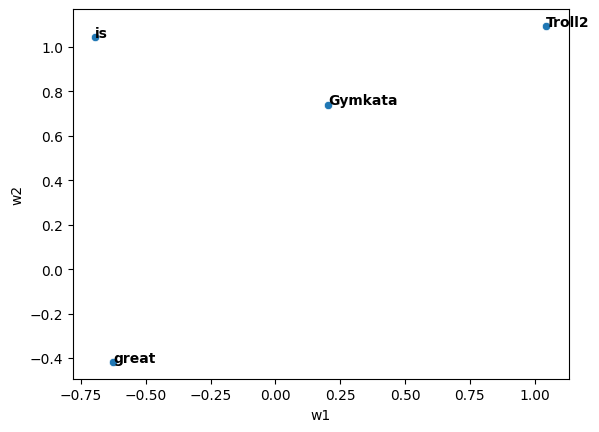

In [29]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token that each dot represents to the graph
# Troll 2
plt.text(df.w1[0], df.w2[0], df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# is
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# great
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# Gymkata
plt.text(df.w1[3], df.w2[3], df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

plt.show()

In the graph we can see that the weights for **Troll2** (representing **input1**) and **Gymkata** (representing **input4**) are no more similar to each other than the other inputs. However, by training this neural network, we hope that those weights will become similar. So lets create a `Trainer` and train the embedding network.

In [39]:
trainer = L.Trainer(max_epochs=1)
trainer.fit(modelFromScratch, train_dataloaders=dataloader)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name         | Type             | Params
--------------------------------------------------
0 | loss         | CrossEntropyLoss | 0     
  | other params | n/a              | 16    
--------------------------------------------------
16        Trainable params
0         Non-trainable params
16        Total params
0.000     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name         | Type             | Params
-------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


>> tensor([0.0163, 0.2050, 0.1693, 0.0629], grad_fn=<StackBackward0>) tensor([0., 1., 0., 0.]) tensor(1.2976, grad_fn=<DivBackward1>)
>> tensor([-0.2543,  0.0263, -0.0464, -0.0949], grad_fn=<StackBackward0>) tensor([0., 0., 1., 0.]) tensor(1.3455, grad_fn=<DivBackward1>)
>> tensor([-0.0897, -0.0440, -0.0168, -0.0383], grad_fn=<StackBackward0>) tensor([0., 0., 0., 1.]) tensor(1.3777, grad_fn=<DivBackward1>)
>> tensor([-0.2608, -0.0918, -0.0110, -0.0997], grad_fn=<StackBackward0>) tensor([0., 1., 0., 0.]) tensor(1.3663, grad_fn=<DivBackward1>)


In [40]:
cl = torch.nn.CrossEntropyLoss()

In [50]:
i0 = torch.tensor([0.0163, 0.2050, 0.1693, 0.0629])
l0 = torch.tensor([0., 1., 0., 0.])
ib0 = torch.tensor([[0.0163, 0.2050, 0.1693, 0.0629]])
lb0 = torch.tensor([1])

In [51]:
cl(i0,l0)

tensor(1.2976)

In [53]:
cl(ib0,lb0)

tensor(1.2976)

Now, with the trained neural network, let's print out the values for each weight...

In [ ]:
print("After optimization, the parameters are...")
for name, param in modelFromScratch.named_parameters():
    print(name, torch.round(param.data, decimals=2))

...and after **100** epochs, the weights for **input1** (`w1 = 2.0244` and `w2 = 1.9754`) are now relatively similar to the weights for **input2** (`w1 = 1.7264` and `w2 = 1.9912`). Just like before, we can illustrate how similar, and different, the embeddings are for all four tokens by plotting them on a graph that has the **w1** values on the x-axis and the **w2** values on the y-axis.

First, let's create the pandas `DataFrame()`...

In [ ]:
data = {
    "w1": [modelFromScratch.input1_w1.item(), ## item() pulls out the tensor value as a float
           modelFromScratch.input2_w1.item(),
           modelFromScratch.input3_w1.item(),
           modelFromScratch.input4_w1.item()],
    "w2": [modelFromScratch.input1_w2.item(),
           modelFromScratch.input2_w2.item(),
           modelFromScratch.input3_w2.item(),
           modelFromScratch.input4_w2.item()],
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

...and then draw the scatterplot...

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.

## Troll 2
plt.text(df.w1[0]-0.2, df.w2[0]+0.1, df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

## is
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

## great
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

## gymkata
plt.text(df.w1[3]-0.3, df.w2[3]-0.3, df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

plt.show()

...and after training the neural network, we see that the weights for **Troll2** and **Gymkata** are relatively similar compared to the weights for the other tokens. This is because both tokens have the same context.

Lastly, we can verify that each token in the vacabulary correctly predicts the token that follows it by running the **one-hot-encoded** input values for each token through the neural network.

In [ ]:
## Let's see what the model predicts

## First, let's create a softmax object...
softmax = nn.Softmax(dim=0) ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

## Now let's...

## print the predictions for "Troll2"
print(torch.round(softmax(modelFromScratch(torch.tensor([[1., 0., 0., 0.]]))),
                  decimals=2))

## print the predictions for "is"
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 1., 0., 0.]]))),
                  decimals=2))

## print the predictions for "great"
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 1., 0.]]))),
                  decimals=2))

## print the predictions for "Gymkata"
print(torch.round(softmax(modelFromScratch(torch.tensor([[0., 0., 0., 1.]]))),
                  decimals=2))

And we see that all tokens correctly predict (give the highest probability to) the token that follows them. In this case, both **Troll2** and **Gymkata** both correctly predict the second token, **is**, with probability **1.0**.

## BAM!!!

----

<a id="build_entirely_with_linear"></a>
# Build and train a Word Embedding Unit using `nn.Linear()`

Now that we can make a Word Embedding network from scratch, let's simplify the code using `nn.Linear()`. `nn.Linear()` will make initialzing the tensors super easy and the math we do in the `forward()` step will also be much simpler.

In [ ]:
class WordEmbeddingWithLinear(L.LightningModule):

    def __init__(self):

        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        L.seed_everything(seed=42)

        ## In order to initialize weights from the 4 inputs (one for each unique word)
        ##       to the 2 nodes in the hidden layer (top and bottom nodes), we simply make
        ##       one call to nn.Linear() where in_features specifies the number of
        ##       inputs and out_features specifies the number of nodes we
        ##       are connecting them to. Since we don't want to use bias terms,
        ##       we set bias=False
        self.input_to_hidden = nn.Linear(in_features=4, out_features=2, bias=False)
        ## Now, in order to connect the 2 nodes in the hidden layer to the 4 outputs, we
        ##       make one call to nn.Linear(), where in_features specifies the number of
        ##       nodes in hidden layer and out_features specifies the number of output values we want.
        ##       And again, we can set bias=False
        self.hidden_to_output = nn.Linear(in_features=2, out_features=4, bias=False)

        ## We'll use CrossEntropyLoss in training_step()
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):

        ## Unlike before, where we did all the math by hand, now we can
        ## simply pass the input values to the weights we created with nn.Linear()
        ## between the input and the hidden layer and save the result in "hidden"
        ##
        ## NOTE: Unlike before, we don't need to strip off the extra brackets from the
        ##       input. the Linear ojbect knows what to do.
        hidden = self.input_to_hidden(input)

        ## Then we pass "hidden" to the weights we created with nn.Linear()
        ## between the hidden layer and the output.
        output_values = self.hidden_to_output(hidden)

        return(output_values)


    def configure_optimizers(self):
        # this configures the optimizer we want to use for backpropagation.

        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch, batch_idx):
        # take a step during gradient descent.

        input_i, label_i = batch # collect input
        output_i = self.forward(input_i) # run input through the neural network
        loss = self.loss(output_i, label_i) ## loss = cross entropy

        return loss

Now that we have created our new `class`, `WordEmbeddingWithLinear`, let's create a model and print out the initial parameters...

In [ ]:
modelLinear = WordEmbeddingWithLinear()

print("Before optimization, the parameters are...")
for name, param in modelLinear.named_parameters():
    print(name, torch.round(param.data, decimals=2))

...and create a `DataFrame` with the embedding values...

In [ ]:
data = {
    ## NOTE: Unlike before, when we called item() on each individual
    ##       Weight, now that we are using nn.Linear, we access the
    ##       Weights with ".weight". We then have to remove the gradients
    ##       associated with each Weight, so we also call .detach().
    ##       Lastly, we then convert the tensor to a numpy array with
    ##       numpy().
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(), # [0] = Weights to top activation function
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(), # [1] = Weights to bottom activation function
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

...and draw a scatter plot of the initial, unoptimized, embedding values...

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph

## Troll 2
plt.text(df.w1[0], df.w2[0], df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
## is
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')
## great
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

## Gymkata
plt.text(df.w1[3], df.w2[3], df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

plt.show()

...and we see that the embedding values for **Troll 2** and **Gymkata** are relatively different. So let's train the model and see if they become more similar.

In [ ]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelLinear, train_dataloaders=dataloader)

In [ ]:
print("After optimization, the parameters are...")
for name, param in modelLinear.named_parameters():
    print(name, param.data)

In [ ]:
data = {
    "w1": modelLinear.input_to_hidden.weight.detach()[0].numpy(),
    "w2": modelLinear.input_to_hidden.weight.detach()[1].numpy(),
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph
## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.

# Troll 2
plt.text(df.w1[0]-0.2, df.w2[0]-0.3, df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# is
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# great
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

# Gymkata
plt.text(df.w1[3]-0.3, df.w2[3]+0.2, df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')

plt.show()

And, after training the model, we see that the embedding values for **Troll 2** and **Gymkata** are more similar than before.

Lastly, we can verify that each token in the vacabulary correctly predicts the token that follows it by running the **one-hot-encoded** input values for each token through the neural network.

In [ ]:
## Let's see what the model predicts
softmax = nn.Softmax(dim=1) ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

print(torch.round(softmax(modelLinear(torch.tensor([[1., 0., 0., 0.]]))), decimals=2)) ## print the predictions for "Troll2"
print(torch.round(softmax(modelLinear(torch.tensor([[0., 1., 0., 0.]]))), decimals=2)) ## print the predictions for "is"
print(torch.round(softmax(modelLinear(torch.tensor([[0., 0., 1., 0.]]))), decimals=2)) ## print the predictions for "great"
print(torch.round(softmax(modelLinear(torch.tensor([[0., 0., 0., 1.]]))), decimals=2)) ## print the predictions for "Gymkata"

## Double BAM!!!

----

<a id="embedding_lookup"></a>
# Use `nn.Embedding()` to load and use pre-trained Word Embeddings

Now that we have created embeddings for each token in the vocabulary, we can store them in an `nn.Embedding()` object so that we can access them with the tokens, rather than the one-hot-encoded versions of the tokens. This makes them easily portable to other applications.

First, let's just print out the embedding values that we created in modelLinear and that we want to add to an `nn.Embedding()` object.

In [ ]:
modelLinear.input_to_hidden.weight

Now let's create an `nn.Embedding()` object and add those Embedding Values to it.

In [ ]:
##  NOTE: We have to transpose the original embedding values (from w1 and w2) for nn.Embedding()
##        and we do this with adding a '.T' to modelLinear.input_to_hidden.weight.T
word_embedings = nn.Embedding.from_pretrained(modelLinear.input_to_hidden.weight.T)

Now let's print out the weights to make sure they are what we expect them to be.

In [ ]:
word_embedings.weight

Now we can access the embeddings for each token directly with an index between 0 and 3, like this...

In [ ]:
word_embedings(torch.tensor(0)) # retrieve the embedding values for Troll 2...

...or we can create a dictionary and access the embedding values with words or tokens instead.

In [ ]:
vocab = {'Troll2': 0,
         'is': 1,
         'great': 2,
         'Gymkata': 3}

In [ ]:
word_embedings(torch.tensor(vocab['Troll2']))

In [ ]:
word_embedings(torch.tensor(vocab['Gymkata']))

# TRIPLE BAM!!!
----

# **Bonus!**
<a id="build_with_embedding"></a>
# Build and train a Word Embedding Unit using `nn.Embedding()` and `nn.Linear()`

Although less commonly done, we can replace `nn.Linear()` from the inputs to the activation functions with `nn.Embedding()` and train the embeddings directly in the lookup table.

In [ ]:
class WordEmbeddingWithEmbedding(L.LightningModule):

    def __init__(self):

        super().__init__()

        ## The first thing we do is set the seed for the random number generorator.
        ## This ensures that when someone creates a model from this class, that model
        ## will start off with the exact same random numbers as I started out with when
        ## I created this demo. At least, I hope that is what happens!!! :)
        L.seed_everything(seed=42)

        self.embed = nn.Embedding(4, 2) # 4 = number of words in the vocabulary, 2 = 2 numbers per embedding
        self.hidden_to_output = nn.Linear(2, 4, bias=False)

        ## We'll use CrossEntropyLoss in training_step()
        self.loss = nn.CrossEntropyLoss()


    def forward(self, input):

        hidden = self.embed(input[0])
        output_values = self.hidden_to_output(hidden)

        return(output_values)


    def configure_optimizers(self): # this configures the optimizer we want to use for backpropagation.
        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch, batch_idx): # take a step during gradient descent.
        input_i, label_i = batch # collect input
        output_i = self.forward(input_i[0]) # run input through the neural network
        loss = self.loss(output_i, label_i[0]) ## self.loss = cross entropy

        return loss

In [ ]:
## Create the training data for the neural network.

## NOTE: nn.Embedding() applies one-hot-encoding to the input for us, so
## the data that we use for training will look different from before.
inputsForEmbed = torch.tensor([[0], [1], [2], [3]]) ## NOTE: Troll2 = 0, is = 1, great = 2, Gymkata = 3
labels = torch.tensor([[0., 1., 0., 0.], [0., 0., 1., 0.], [0., 0., 0., 1.], [0., 1., 0., 0.]])

datasetForEmbed = TensorDataset(inputsForEmbed, labels)
dataloaderForEmbed = DataLoader(datasetForEmbed)

In [ ]:
modelEmbed = WordEmbeddingWithEmbedding()

print("Before optimization, the parameters are...")
for name, param in modelEmbed.named_parameters():
    print(name, param.data)

In [ ]:
weights = modelEmbed.embed.weight.detach().numpy()
w1 = [weights[0][0], weights[1][0], weights[2][0], weights[3][0]]
w1

In [ ]:
w2 = [weights[0][1], weights[1][1], weights[2][1], weights[3][1]]
w2

In [ ]:
data = {
    "w1": w1,
    "w2": w2,
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph
## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.
plt.text(df.w1[0], df.w2[0], df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # Troll 2
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # is
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # great
plt.text(df.w1[3], df.w2[3], df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # Gymkata

plt.show()

In [ ]:
trainer = L.Trainer(max_epochs=100)
trainer.fit(modelEmbed, train_dataloaders=dataloaderForEmbed)

In [ ]:
print("After optimization, the parameters are...")
for name, param in modelEmbed.named_parameters():
    print(name, param.data)

In [ ]:
weights = modelEmbed.embed.weight.detach().numpy()
w1 = [weights[0][0], weights[1][0], weights[2][0], weights[3][0]]
w2 = [weights[0][1], weights[1][1], weights[2][1], weights[3][1]]

In [ ]:
data = {
    "w1": w1,
    "w2": w2,
    "token": ["Troll2", "is", "great", "Gymkata"],
    "input": ["input1", "input2", "input3", "input4"]
}
df = pd.DataFrame(data)
df

In [ ]:
sns.scatterplot(data=df, x="w1", y="w2")

## add the token each dot represents to the graph
## NOTE: For Troll2 and and Gymkata, we're adding offsets to where to print the tokens because otherwise
## they will be so close to each other that they will overlap and be unreadable.
plt.text(df.w1[0]-0.2, df.w2[0]-0.3, df.token[0],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # Troll 2
plt.text(df.w1[1], df.w2[1], df.token[1],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # is
plt.text(df.w1[2], df.w2[2], df.token[2],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold') # great
plt.text(df.w1[3]-0.3, df.w2[3]+0.2, df.token[3],
         horizontalalignment='left',
         size='medium',
         color='black',
         weight='semibold')# Gymkata

plt.show()

In [ ]:
## Let's see what the model predicts
softmax = nn.Softmax(dim=0) ## dim=0 applies softmax to rows, dim=1 applies softmax to columns

print(torch.round(softmax(modelEmbed(torch.tensor([0])).detach()), decimals=2)) ## print the predictions for "Troll2"
print(torch.round(softmax(modelEmbed(torch.tensor([1])).detach()), decimals=2)) ## print the predictions for "is"
print(torch.round(softmax(modelEmbed(torch.tensor([2])).detach()), decimals=2)) ## print the predictions for "great"
print(torch.round(softmax(modelEmbed(torch.tensor([3])).detach()), decimals=2)) ## print the predictions for "Gymkata"

# BONUS BAM!!!